**Make panels comparing two UKESM1 sims **

In [2]:
import sys
print(sys.version)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import cartopy.crs as ccrs

# load some useful functions written or acquired by phil rasch
%run -i ./pjrlib

3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]


In [3]:
def setfig3b1x1 ():
    """
    return fig and axes for a single panel figure
    """
    plotproj = ccrs.Mollweide(central_longitude=-80)
    plotproj._threshold /= 100.
    fig, axes = plt.subplots(ncols=1,
                             gridspec_kw={'width_ratios': [1]},
                             subplot_kw={'projection': plotproj},
                             figsize=(6,4.1),
                            )
    fig.set_dpi(300.0)
    return fig, axes;

def pltllbox(xri, yri,ax=None):
    if ax is None:
        ax = plt.gca()
    if xri[1] < xri[0]:
        xri[1] += 360.
    regcx = [xri[0],xri[1],xri[1],xri[0],xri[0]]
    regcy = [yri[0],yri[0],yri[1],yri[1],yri[0]]
    ax.plot(regcx,regcy,color='red',transform=ccrs.PlateCarree())

In [4]:
def fix_UKMO_ds(filename, dsin: xr.Dataset) -> xr.Dataset:
    """
    Rename some variables and rescale 
    :param ds: some xarray dataset
    :return: a normalized xarray dataset, or the original one
    """

    #print('filename is ', filename)
    name_dict = dict()
    ds = dsin.copy()
    ds = _normalize_lat_lon(ds) # harmonize the lat, lon fields
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    #print('ds',ds)
    for Vname in ds:
        #print('Vname',Vname)
        if (('PBL' in filename) & ('height_after' in Vname)):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'kg/m2'
            ds[Vname].attrs['long_name'] = 'PBL height'
            ds = ds.rename({Vname:'PBLH'})
            #print('fixed PBLH')
            
        if (('LWP' in filename) & (Vname == 'm01s02i391')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'kg/m2'
            ds[Vname].attrs['long_name'] = 'Liq Water Path'
            ds = ds.rename({Vname:'TGCLDLWP'})
            #print('fixed LWP')
            
        if (('AOD' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = '1'
            ds[Vname].attrs['long_name'] = 'AOD 550nm'
            ds = ds.rename({Vname:'AOD'})
    
        if (('_r_e' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['long_name'] = 'Effective Radius at Cloud-top'
            ds[Vname].attrs['units'] = '$\mu m$'
            ds = ds.rename({Vname:'REPJR'})
            #print('fixed RE')

        if (('precip_rate' in filename) & (Vname == 'precipitation_flux')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'm/s'
            ds[Vname] = ds[Vname]/1000.
            ds[Vname].attrs['long_name'] = 'Total Precipitation'
            ds = ds.rename({Vname:'PRECT'})
            #print('fixed PRECT')
           
        if (('p_surface_Pa' in filename) & (Vname == 'surface_air_pressure')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname] = ds[Vname]/100.
            ds[Vname].attrs['units'] = 'hPa'
            ds[Vname].attrs['long_name'] = ds[Vname].attrs['standard_name']
            ds = ds.rename({Vname:'PS'})
            #print('fixed PS')
        
        if (('cloud_fraction' in filename) & (Vname == 'cloud_area_fraction_in_atmosphere_layer')):
            ds[Vname].attrs['UKESM name'] = Vname
            #ds[Vname] = ds[Vname]/100.
            #ds[Vname].attrs['units'] = 'hPa'
            #ds[Vname].attrs['long_name'] = ds[Vname].attrs['standard_name']
            ds = ds.rename({Vname:'CLOUD'})
        
        if (('T_surface_K' in filename) & (Vname == 'surface_temperature')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['long_name'] = ds[Vname].attrs['standard_name']
            ds = ds.rename({Vname:'TS'})
            #print('fixed TS')
            
        if (('net_ToA_SW_W' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'W/m2'
            ds[Vname].attrs['long_name'] = 'Net TOA Shortwave'
            ds = ds.rename({Vname:'FSNT'})
            #print('fixed FSNT')
            
        if (('net_ToA_SW_C' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'W/m2'
            ds[Vname].attrs['long_name'] = 'Net TOA Shortwave Clear'
            ds = ds.rename({Vname:'FSNTC'})
            #print('fixed FSNT'
            
        if (('_SW_Clear' in filename) & (Vname == 'toa_outgoing_shortwave_flux_assuming_clear_sky')):
            ds[Vname] = -ds[Vname]
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'W/m2'
            ds[Vname].attrs['long_name'] = 'outgoing SW assuming clearsky (upward -ive)'
            ds = ds.rename({Vname:'MFSUTC'})
              

    return ds

In [5]:
Vdict = {'net_ToA_LW_W_m2':'toa_outgoing_longwave_flux'
        ,'net_ToA_SW_W_m2':'FSNT'
        ,'net_ToA_SW_Clear_W_m2':'FSNTC'
        ,'AOD_550nm':'AOD'
        ,'LWP_kg_m2':'TGCLDLWP'
        ,'p_surface_Pa':'PS'
        ,'T_surface_K':'TS'
        ,'precip_rate_kg_m2_sec':'PRECT'
        ,'PBL_depth_metres':'PBLH'
        ,'cloudtop_r_e_microns':'REPJR'
        ,'cloud_fraction':'CLOUD'
        ,'Outgoing_SW_Clear_W_m2':'MFSUTC'
        }



In [6]:
def xr_llhplot2 (xrVar, cbar='default', plotproj=None, ax=None, cax=None, fig=None,
                 ylabels=False, clevs=None, cmap=None, title=None, cbartitle=None):
    """xr_llhplot xarray lat lon horizontal plot
    """
    #print(' entering xr_llhplot', xrVar)
    
    lon=xrVar['lon'].values
    lat=xrVar['lat'].values
    xv,yv=np.meshgrid(lon,lat)
    data_regridded = xrVar.values
    #print('aaa',data_regridded.shape, xv.shape, yv.shape)
    df = data_regridded.flatten()
    dsub = df[np.isfinite(df)] # ignore NaN
    zmax = dsub.max()
    zmin = dsub.min()
    #print('masked interpolated range',zmin,zmax)
    dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
    if ylabels is None: ylabels = True
    if clevs is None:
        clevs = findNiceContours(np.array([zmin,zmax]),nlevs=10)
    #print('clevs',clevs)
    if cmap is None:
        #print('aaa, grabbing cmap default')
        #cmap = mpl.cm.get_cmap()
        cmap = plt.get_cmap()
        #print('bbb',cmap.N)
    #print('cmap',cmap)
    extend = 'both'
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N,extend=extend)
    #print('norm',norm(clevs))
    clat = (lat.min()+lat.max())/2.
    clon = (lon.min()+lon.max())/2.
    if plotproj is None:
        plotproj = ccrs.PlateCarree()
        plotproj = ccrs.Mollweide(central_longitude=-80.)
 
    # if no ax argument, could get current axis, or create it
    if ax is None:
        #print('grab current axis')
        #ax = plt.gca()
        ax = plt.axes(projection=plotproj)
        
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=2, color='gray', alpha=0.5)
    pl = ax.contourf(xv, yv, data_regridded, levels=clevs, # vmin=zmin, vmax=zmax,
                     norm=norm, cmap=cmap,
                     extend=extend, transform=ccrs.PlateCarree())
    
    gl.left_labels=ylabels
    gl.right_labels=ylabels
    ax.coastlines(linewidth=1,color='blue')
 
    ## Find the location of the main plot axes
    ## has to be done after some plotting is done in projection space
    posn = ax.get_position()
    
    # print some registration marks to help in lining up figures
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.scatter([0,0,1,1], [0,1,0,1], c="r", s=100)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])

    if not title is None:
        #ax.set_title(title)
        ax2.text(0.01,0.9,title)
    
    # Add colorbar to plot
    if cbartitle is None:
        cbartitle = xrVar.long_name
        
    if cbar == 'default':
        if cax is not None:
            cax = ax
        else:
            # create an colorbar axis
            cax = fig.add_axes([0,0,0.1,0.1])
            ## Adjust the positioning and orientation of the colorbar
            cax.set_position([posn.x0, posn.y0-0.07, posn.width, 0.05])

        cb = plt.colorbar(
             pl, orientation='horizontal',ticks=clevs,cax=cax,
             label='%s (%s)'%(cbartitle, xrVar.units),
             )
        cb.ax.tick_params(labelsize=11)
        #cb.ax.set_yticklabels(['{:.0f}'.format(x) for x in clevs])#, fontsize=16, weight='bold')
        if len(clevs) > 15:
            clevs2 = findNiceContours(clevs,nlevs = 10, rmClev=0.,sym=True)
            cb.set_ticks(clevs2)
            cb.set_ticklabels(clevs2)
            #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            cb.ax.set_xticklabels(["{:.0f}".format(i) for i in clevs2]) # set ticks of your format


        
    return

In [7]:
def pltfld(DV, titled, fname=None):
    
    cbartitle = DV.long_name
    
    if DV.min().values == DV.max().values:
        print('constant field skipping plot ')
    else:
        dlev_rng = {'CDNUMC':np.array([0.,3.e11])/2.,'FSNT':np.array([-45.,45.]),
                    'FSNTC':np.array([-20.,20.]),
                    'TGCLDLWP':np.array([-50.,50.]),'PRECL':np.array([-1.,1.]),
                    #'TGCLDLWP':np.array([-80.,80.]),'PRECL':np.array([-1.,1.]),
                    'PRECT':np.array([-5.,5.]),'SWCF':np.array([-45.,45.]),
                    'CLDLOW':np.array([-10.,10.]),'CLOUD':np.array([-10.,10.]),
                   }
        if DV.name in dlev_rng:
            dlevs = findNiceContours(dlev_rng[DV.name],nlevs = 15,rmClev=0.,sym=True)
        else:
            dlevs = findNiceContours(np.array([DV.min().values,DV.max().values]),nlevs = 15, rmClev=0.,sym=True)
        #dlevs = [-5.,-2.,-1.,-0.5,-0.2,-0.1,0.1,0.2,0.5,1.,2.,5.]
        dmap = diverge_map()

        fig, axes = setfig3b1x1()
        xr_llhplot2(DV, fig=fig, ax=axes,clevs=dlevs,cmap=dmap,title=titled, cbartitle=cbartitle)
        pltllbox([-150.,-110.],[0.,30.],ax=axes)
        pltllbox([-110.,-70.],[-30.,0.],ax=axes)
        pltllbox([-25.,15.],[-30.,0.],ax=axes)
        if fname is not None:
            print('fname',fname)
            plt.savefig(fname,dpi=300,transparent=True)
        plt.show()



In [8]:
pref_fn = 'UKESM'

def make_ind1 (REG_ID, Varname, filetype=None):
    case_start1 = '~/NetCDF_Files/UKESM1_data/'+REG_ID+'_20450101_20490101_mean_'
    case_start1 = '~/NetCDF_Files/UKESM1_data_v2/Coupled_50Tg/'+REG_ID+'_coupled_50Tgy_20410101_20500101_mean_'
    case_end1 = ".nc"
    fstring1 ='%s%s%s' 
    pref1=REG_ID+'_UKESM1_50Tgpy_Cpld'
    
    if filetype == 'Fixed_SST':
        # fixed SST simulations
        case_start1 = '~/NetCDF_Files/UKESM1_data/'+REG_ID+'_AtmosOnly_19840101_19880101_mean_'
        pref1=REG_ID+'_50Tgpy_FixedSST'
        case_start1 = '~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/'+REG_ID+'_AtmosOnly_25Tgy_19790101_19890101_mean_'
        pref1=REG_ID+'_25Tgpy_FixedSST'
        #case_start1 = '~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_50Tg_1979-1989/'+REG_ID+'_AtmosOnly_50Tgy_19790101_19890101_mean_'
        #pref1=REG_ID+'_50Tgpy_FixedSST'
        case_end1 = ".nc"
        fstring1 ='%s%s%s' 
        pref1=REG_ID+'_UKESM1_25Tgpy_Cpld'

    ind1 = fstring1 % (case_start1,Varname,case_end1)
    return ind1

def make_ind2(REG_ID, Varname, filetype='Fixed_SST'):    
    case_start2 = '~/NetCDF_Files/UKESM1_data/CTL_20450101_20490101_mean_'
    case_start2 = '~/NetCDF_Files/UKESM1_data_v2/Coupled_Control/CTL_coupled_20410101_20500101_mean_'
    case_end2 = ".nc"
    pref2='UKESM1_control'
    fstring2 ='%s%s%s' 

    if filetype == 'Fixed_SST':
        case_start2 = '~/NetCDF_Files/UKESM1_data/CTL_AtmosOnly_19840101_19880101_mean_'
        case_start2 = '~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/'+'CTL_AtmosOnly_19790101_19890101_mean_'
        case_end2 = ".nc"
        pref2='Control'
        fstring2 ='%s%s%s' 
        
    ind2 = fstring2 % (case_start2,Varname,case_end2)
    return ind2




-------------------------------LWP_kg_m2
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R1_NEP_AtmosOnly_25Tgy_19790101_19890101_mean_LWP_kg_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_LWP_kg_m2.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R2_SEP_AtmosOnly_25Tgy_19790101_19890101_mean_LWP_kg_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_LWP_kg_m2.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R3_SEA_AtmosOnly_25Tgy_19790101_19890101_mean_LWP_kg_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_LWP_kg_m2.nc
 all regions summed
fname UKESM_LWP_kg_m2_TGCLDLWP-D.pdf


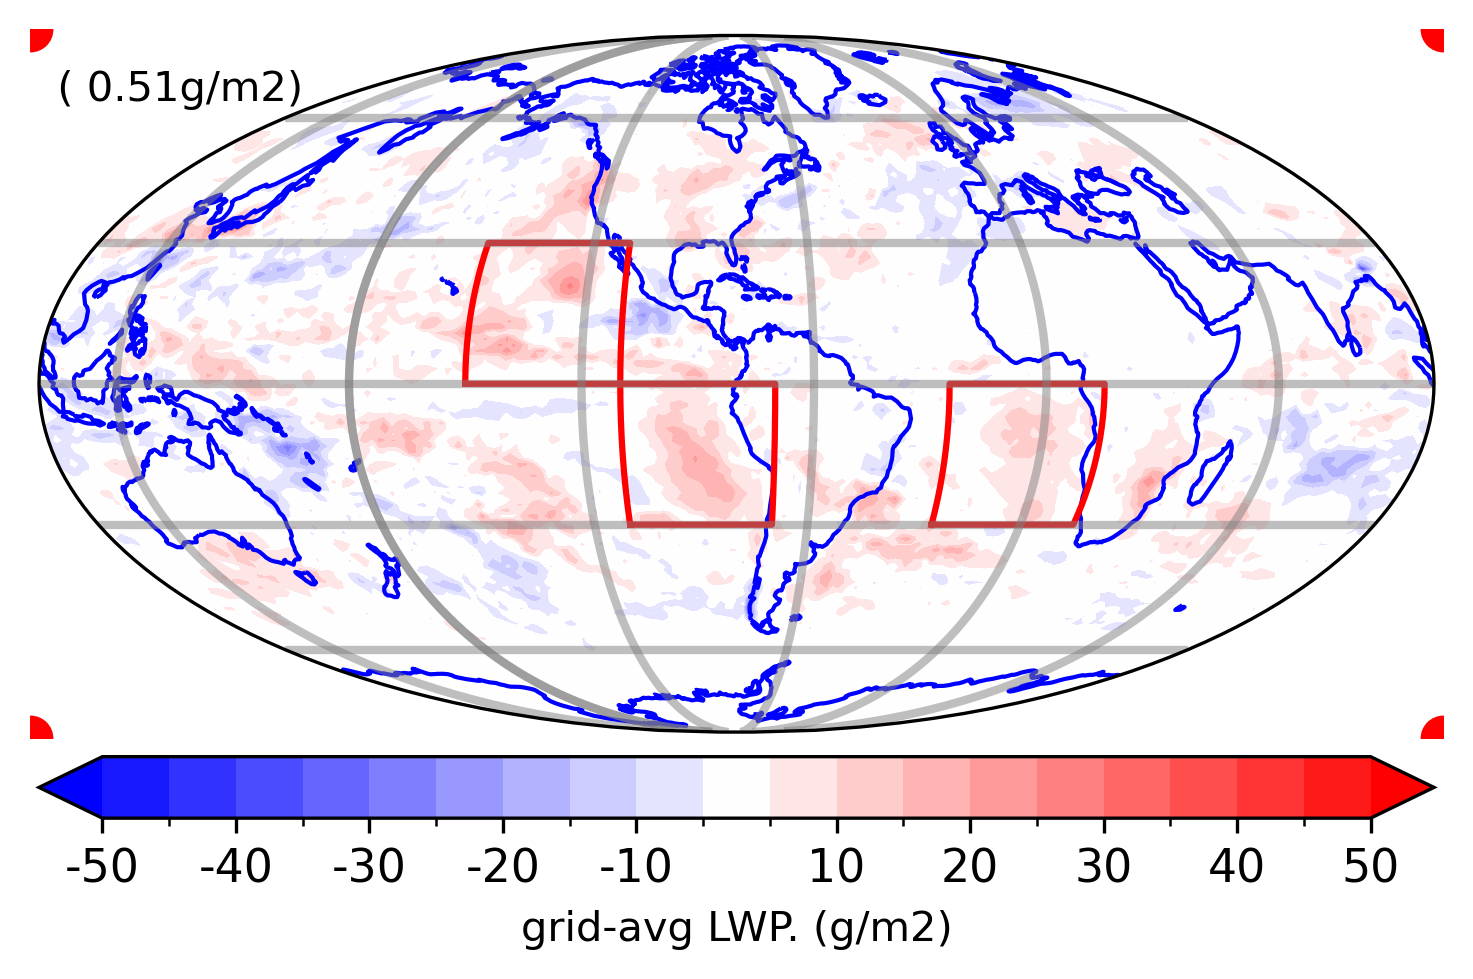

field processing complete

-------------------------------net_ToA_SW_Clear_W_m2
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R1_NEP_AtmosOnly_25Tgy_19790101_19890101_mean_net_ToA_SW_Clear_W_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_net_ToA_SW_Clear_W_m2.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R2_SEP_AtmosOnly_25Tgy_19790101_19890101_mean_net_ToA_SW_Clear_W_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_net_ToA_SW_Clear_W_m2.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R3_SEA_AtmosOnly_25Tgy_19790101_19890101_mean_net_ToA_SW_Clear_W_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_net_ToA_SW_Clear_W_m2.nc
 all regions summed
fname UKESM_net_ToA_SW_Clear_W_m2_FSNTC-D.pdf


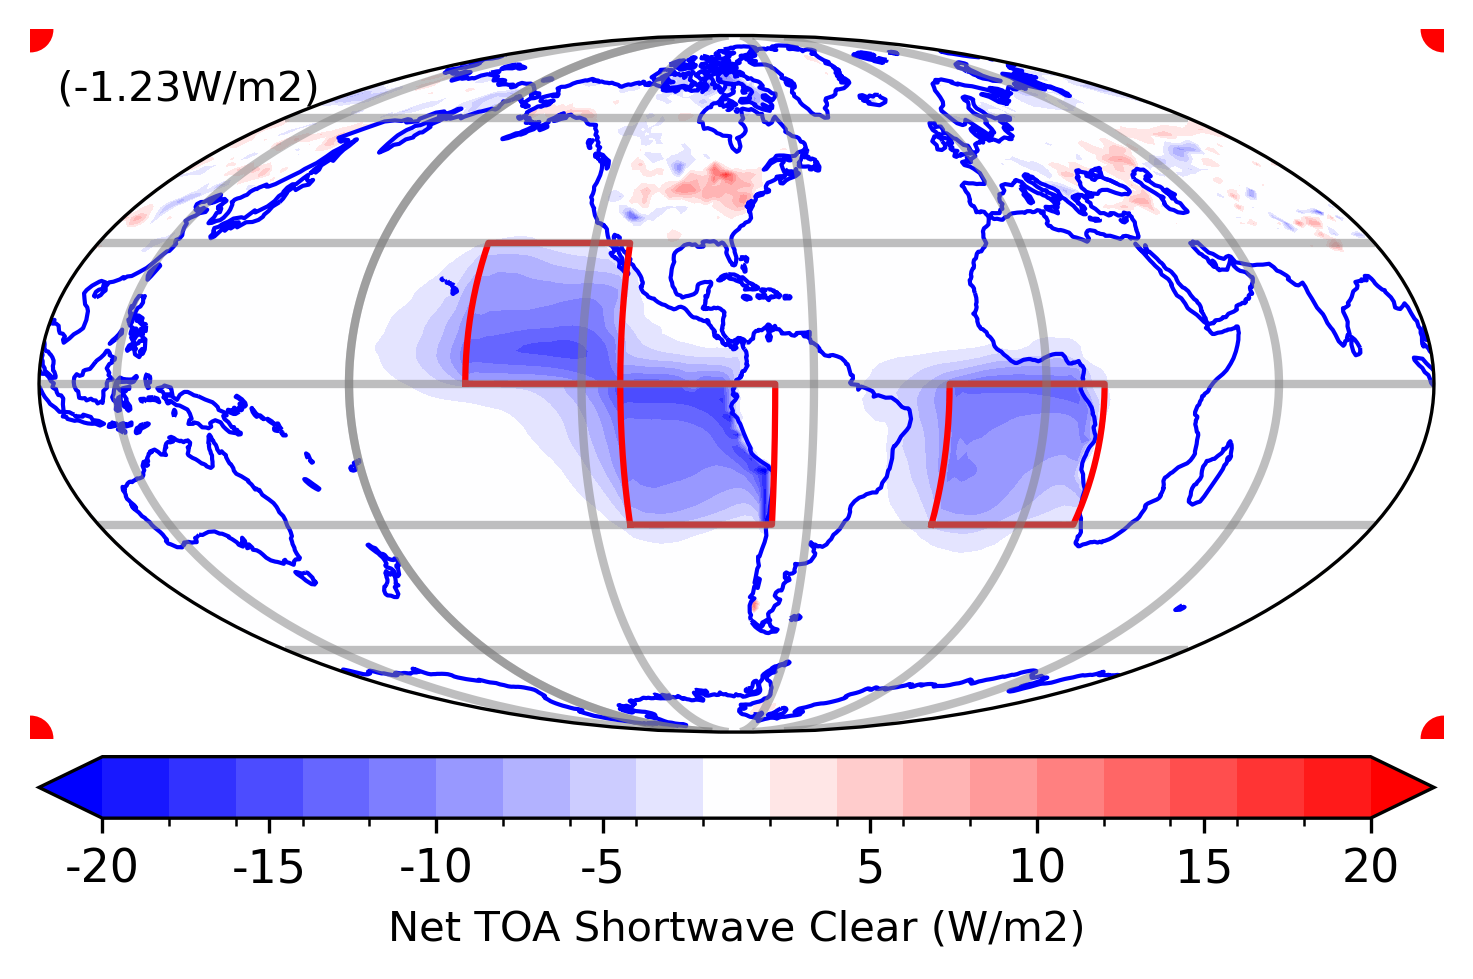

field processing complete

-------------------------------net_ToA_SW_W_m2
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R1_NEP_AtmosOnly_25Tgy_19790101_19890101_mean_net_ToA_SW_W_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_net_ToA_SW_W_m2.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R2_SEP_AtmosOnly_25Tgy_19790101_19890101_mean_net_ToA_SW_W_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_net_ToA_SW_W_m2.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R3_SEA_AtmosOnly_25Tgy_19790101_19890101_mean_net_ToA_SW_W_m2.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_net_ToA_SW_W_m2.nc
 all regions summed
fname UKESM_net_ToA_SW_W_m2_FSNT-D.pdf


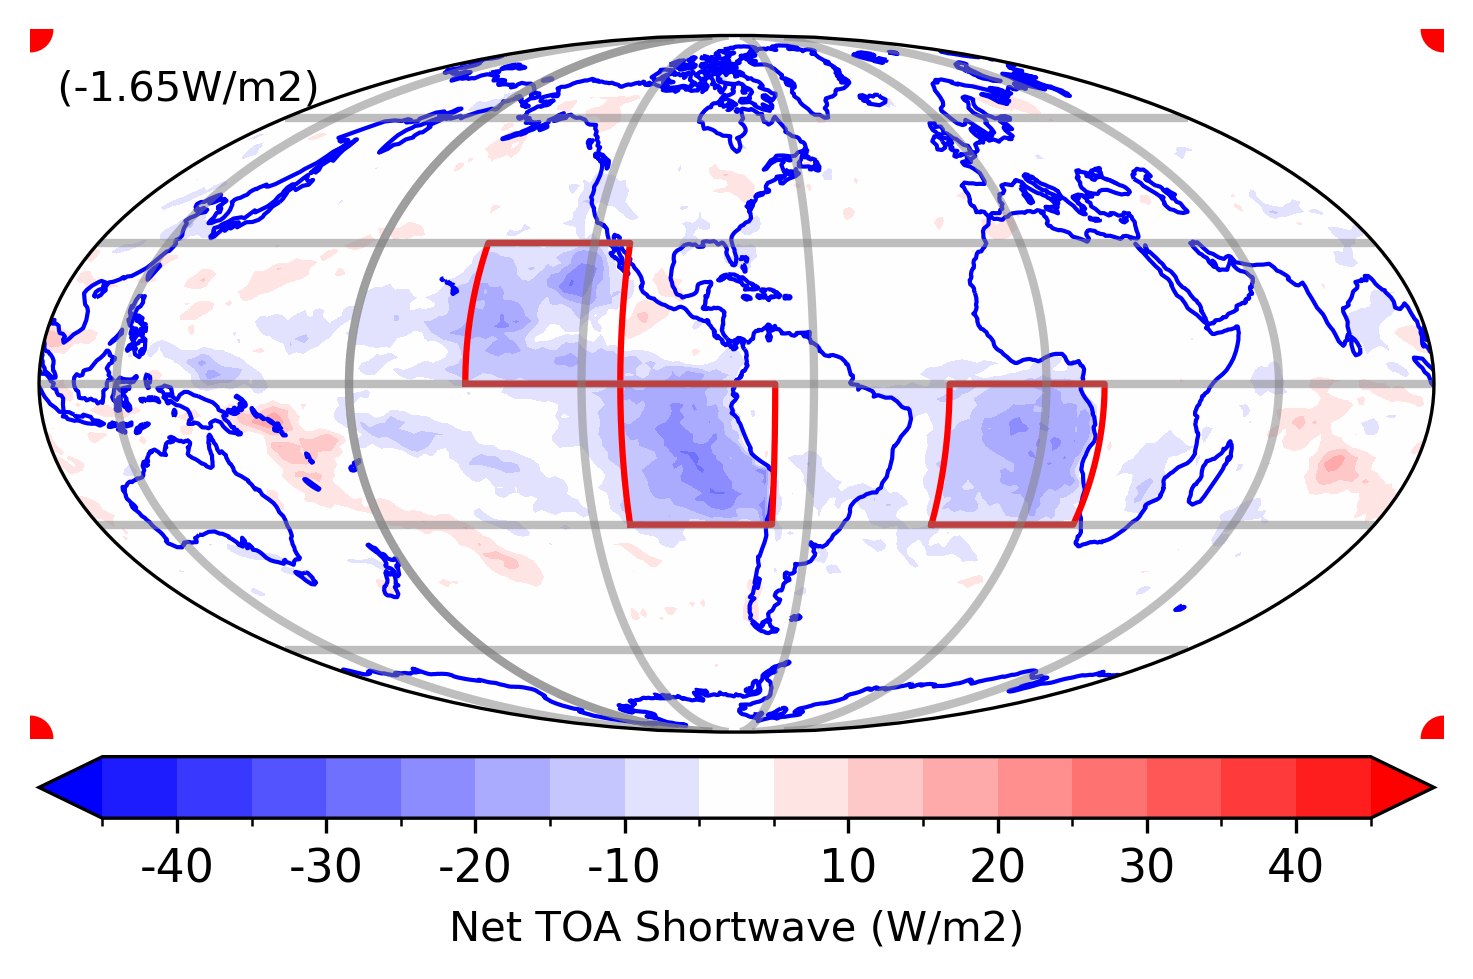

field processing complete

-------------------------------cloud_fraction
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R1_NEP_AtmosOnly_25Tgy_19790101_19890101_mean_cloud_fraction.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_cloud_fraction.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R2_SEP_AtmosOnly_25Tgy_19790101_19890101_mean_cloud_fraction.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_cloud_fraction.nc
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/R3_SEA_AtmosOnly_25Tgy_19790101_19890101_mean_cloud_fraction.nc
ind2 opening ~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/CTL_AtmosOnly_19790101_19890101_mean_cloud_fraction.nc
 all regions summed


/home/jupyter-adminphil/.conda/envs/pjrpy3/lib/python3.11/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


fname UKESM_cloud_fraction_CLOUD-D.pdf


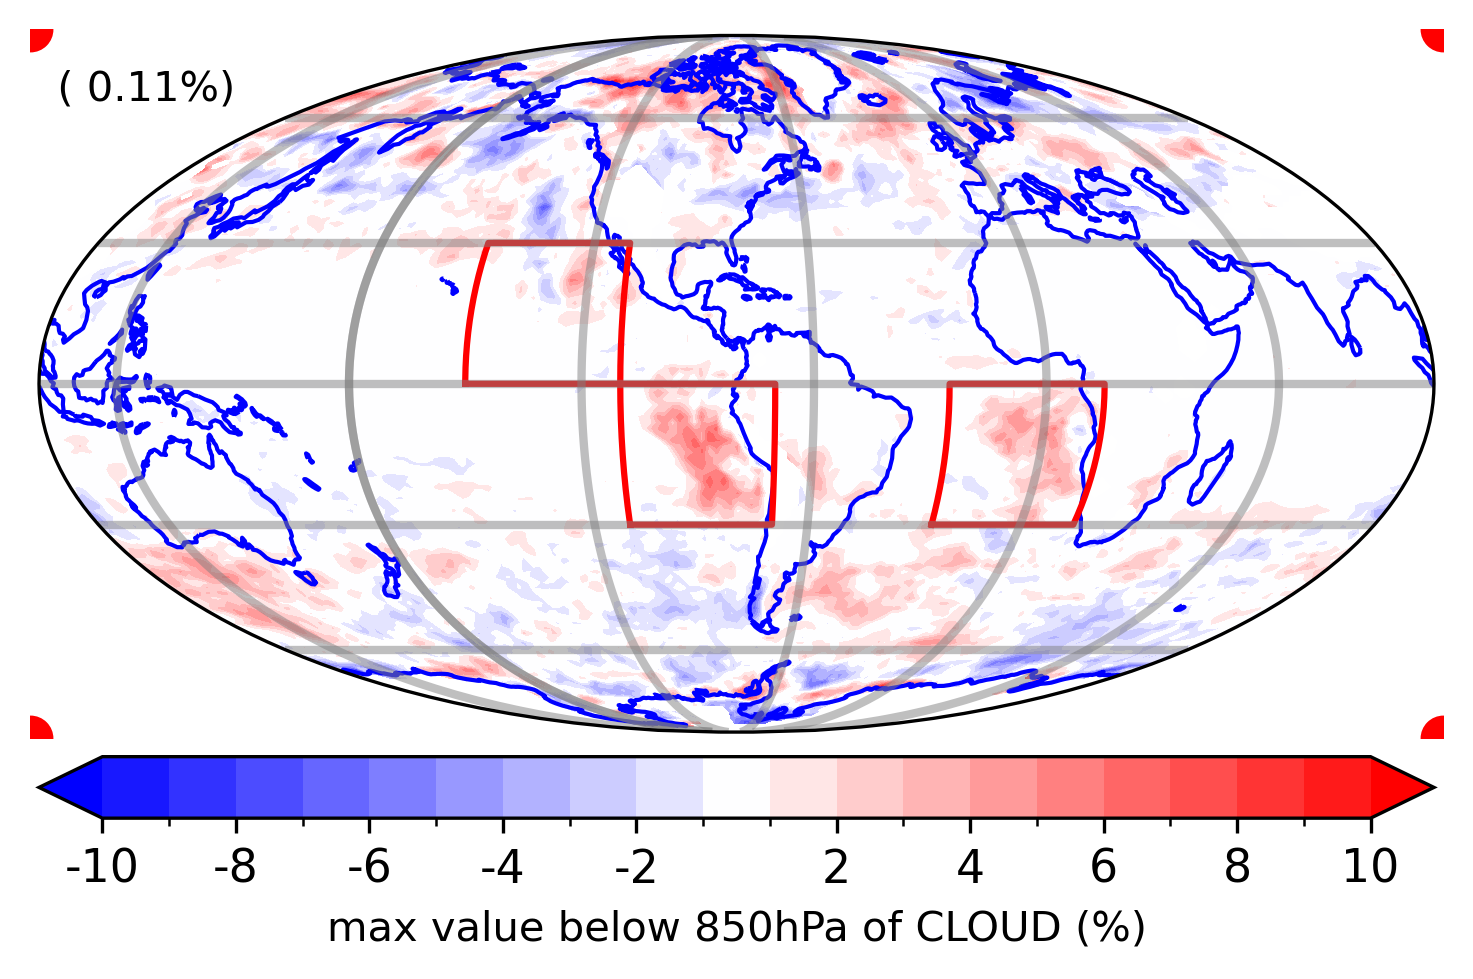

field processing complete
fname UKESM_cloud_fraction_SWCRE-D.pdf


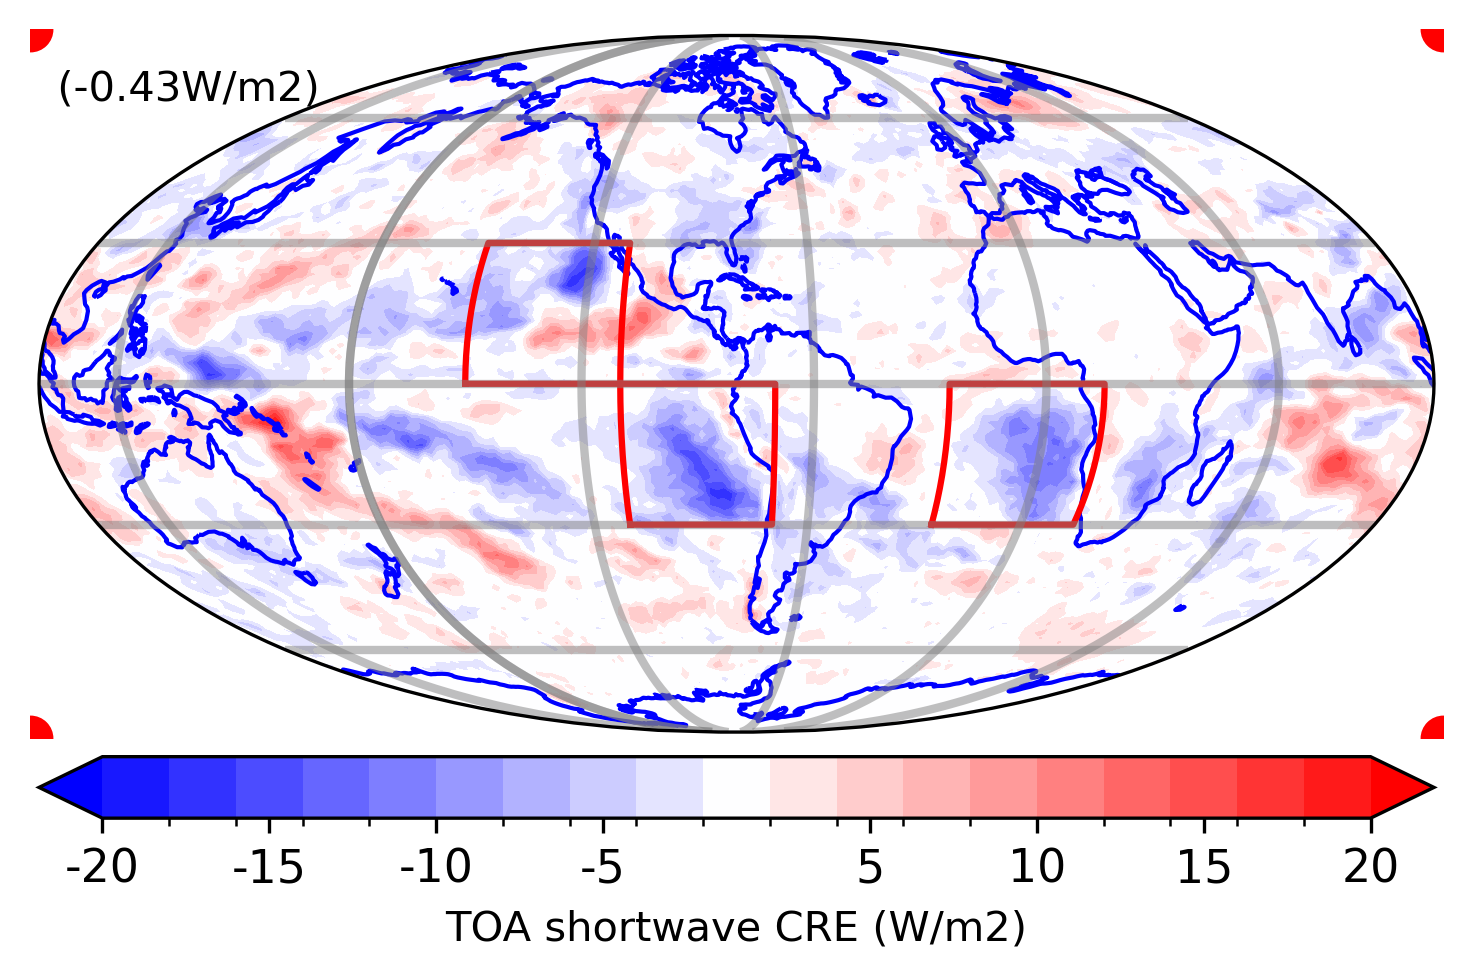

In [9]:
# accumulate differences over 3 areas

difftitle=""

#Varlist = np.array(['p_surface_Pa'])
#Varlist = np.array(['Outgoing_SW_Clear_W_m2','p_surface_Pa','T_surface_K','precip_rate_kg_m2_sec','PBL_depth_metres','cloudtop_r_e_microns','AOD_550nm','LWP_kg_m2','net_ToA_LW_W_m2','net_ToA_SW_W_m2'])
Varlist = np.array(['Outgoing_SW_Clear_W_m2','precip_rate_kg_m2_sec','PBL_depth_metres','cloudtop_r_e_microns','AOD_550nm','LWP_kg_m2','net_ToA_LW_W_m2','net_ToA_SW_W_m2',
                    'net_ToA_SW_Clear_W_m2','cloud_fraction'])
Varlist = np.array(['net_ToA_SW_Clear_W_m2','net_ToA_SW_W_m2'])
#Varlist = np.array(['net_ToA_SW_Clear_W_m2','net_ToA_SW_W_m2'])
#Varlist = np.array(['AOD_550nm','LWP_kg_m2','net_ToA_LW_W_m2','net_ToA_SW_W_m2'])
#Varlist = np.array(['T_surface_K'])
Varlist = np.array(['LWP_kg_m2','net_ToA_SW_Clear_W_m2','net_ToA_SW_W_m2','cloud_fraction'])
#Varlist = np.array(['precip_rate_kg_m2_sec'])

FSNT1 = None
FSNT2 = None
FSNTC1 = None
FSNTC2 = None

# specify regions (assume lon always specified as west, then east limit)
xreg = np.array([[-150.,-110.],[-110,-70],[-25.,15.],[170.,-120.],[-170.,-90.]])%360.
yreg = np.array([[0.,30.],     [-30.,0.], [-30.,0.], [30.,50.],   [-50.,-30.] ])
namereg = ['NEP','SEP','SEA','NP','SP']
#xreg = [[0.,360.]]
#yreg = [[-90.,91.]]


reglist = np.array(['R1_NEP','R2_SEP','R3_SEA'])
#reglist = np.array(['R2_SEP'])


filetype = None
filetype = 'Coupled'
filetype = 'Fixed_SST'

for Varname in Varlist:
    print()
    print('-------------------------------'+Varname)
    nreg = 0 # is it the start of the region summation
    for REG_ID in reglist:
        ind1 = make_ind1(REG_ID,Varname,filetype)
        print('ind1 opening',ind1)
        DS1 = xr.open_mfdataset(ind1)
        # update the dataset
        DS1 = fix_UKMO_ds(ind1, DS1)
        VN = Vdict[Varname]
        V1 = xr_getvar_sl(VN,DS1,method='maxb850')
        ind2 = make_ind2(REG_ID,Varname,filetype)
        print('ind2 opening',ind2)
        DS2 = xr.open_mfdataset(ind2)
        DS2 = fix_UKMO_ds(ind2, DS2)
        V2 = xr_getvar_sl(VN,DS2,method='maxb850')

        DV = V1-V2
        weights = None
        if 'area' in DS1:
            area = DS1['area']
        elif 'area' in DS2:
            area = DS2['area']
        else:
            lat = V1['lat'].values
            lon = V1['lon'].values
            area = make_fvarea(lon,lat)
        weights = V1.copy()
        weights.data =area
        weights.attrs['units']='steradians'

        V1A = V1.weighted(weights).mean()
        sV1A = ' (%5.2f)' % V1A
        V2A = V2.weighted(weights).mean()
        sV2A = ' (%5.2f)' % V2A
        DVA = V1A-V2A
        sDVA = ' (%5.2f)' % DVA
        if nreg == 0:
            V1S = V1
            V2S = V2
            DVS = DV
            nreg = 1
        else:
            V1S = V1S + V1
            V2S = V2S +V2
            DVS = DVS + DV
            nreg = nreg+1
    
    print(' all regions summed')
    #V1S = V1S/nreg
    #V2S = V2S/nreg

    DVA = DVS.weighted(weights).mean()
    sDVA = ' ({:5.2f}{:s})'.format(DVA.values, DVA.units)

    fname = pref_fn+'_'+Varname+'_'+DV.name+'-D.pdf'
    pltfld(DVS, difftitle+sDVA,fname)

    if VN == 'FSNT':
        FSNT1=V1S
        FSNT2=V2S
    elif VN == 'FSNTC':
        FSNTC1=V1S
        FSNTC2=V2S
    
    print('field processing complete')

if ((FSNT1 is None) or (FSNTC1 is None)):
    print ('fields for SWCRE not requested')
else:
    SWCRE1 = FSNT1-FSNTC1
    SWCRE1.attrs['long_name'] = 'TOA shortwave CRE'
    SWCRE1 = SWCRE1.rename('SWCRE')
    SWCRE2 = FSNT2-FSNTC2
    SWCRE2.attrs['long_name'] = 'TOA shortwave CRE'
    SWCRE2 = SWCRE2.rename('SWCRE')
    DSWCRE = SWCRE1-SWCRE2
    DSWCREA = DSWCRE.weighted(weights).mean()
    sDSWCREA = ' ({:5.2f}{:s})'.format(DSWCREA.values, DSWCREA.units)
    fname = pref_fn+'_'+Varname+'_'+'SWCRE'+'-D.pdf'
    pltfld(DSWCRE, difftitle+sDSWCREA,fname)
